In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.linear_model import Ridge, Lasso, LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, cross_validate, RepeatedKFold
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn import metrics
import matplotlib.ticker as mtick
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Importing the Data

## Data importing and converting to DataFrame

In [4]:
data = pd.DataFrame(pd.read_csv("../data/employee_churn.csv"))

In [5]:
data.head()

,Age,Gender,MonthlyIncome,Department,NumCompaniesWorked,Over18,workingfromhome,BusinessTravel,DistanceFromHome,StandardHours,JobSatisfaction,complaintfiled,complaintresolved,complaintyears,PercentSalaryHike,PerformanceRating,TotalWorkingYears,YearsAtCompany,YearsSinceLastPromotion,Left
0,31,Female,low,Research & Development,1,Y,0,Travel_Rarely,2,40,4,1,Y,0.0,11,1,1,1,0,No
1,32,Male,low,Research & Development,0,Y,0,Travel_Frequently,2,40,4,0,NaN,NaN,13,2,8,7,3,No
2,34,Female,medium,Research & Development,3,Y,1,Travel_Rarely,8,40,1,0,NaN,NaN,14,3,7,0,0,No
3,49,Male,high,Research & Development,4,Y,0,Travel_Rarely,1,40,3,0,NaN,NaN,14,3,23,8,0,No
4,27,Male,medium,Research & Development,1,Y,0,Travel_Rarely,19,40,1,0,NaN,NaN,11,1,7,7,0,No


# Data Preprocessing

In [6]:
data.isna().sum()

Age                           0
Gender                        0
MonthlyIncome                 0
Department                    0
NumCompaniesWorked            0
Over18                        0
workingfromhome               0
BusinessTravel                0
DistanceFromHome              0
StandardHours                 0
JobSatisfaction               0
complaintfiled                0
complaintresolved          1180
complaintyears             1211
PercentSalaryHike             0
PerformanceRating             0
TotalWorkingYears             0
YearsAtCompany                0
YearsSinceLastPromotion       0
Left                          0
dtype: int64

In [7]:
data = data.astype({'Age':'float','NumCompaniesWorked':'float','workingfromhome':'float','DistanceFromHome':'float','JobSatisfaction':'float',
                    'complaintfiled':'float','PercentSalaryHike':'float','PerformanceRating':'float','TotalWorkingYears':'float',
                    'YearsAtCompany':'float','YearsSinceLastPromotion':'float'})

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1474 entries, 0 to 1473
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      1474 non-null   float64
 1   Gender                   1474 non-null   object 
 2   MonthlyIncome            1474 non-null   object 
 3   Department               1474 non-null   object 
 4   NumCompaniesWorked       1474 non-null   float64
 5   Over18                   1474 non-null   object 
 6   workingfromhome          1474 non-null   float64
 7   BusinessTravel           1474 non-null   object 
 8   DistanceFromHome         1474 non-null   float64
 9   StandardHours            1474 non-null   int64  
 10  JobSatisfaction          1474 non-null   float64
 11  complaintfiled           1474 non-null   float64
 12  complaintresolved        294 non-null    object 
 13  complaintyears           263 non-null    float64
 14  PercentSalaryHike       

In [11]:
data_clean = data.drop(columns = ['complaintresolved','complaintyears'] )

Removing redundant or missing features

In [12]:
data_clean = data.drop(columns = ['Over18','StandardHours'])

In [13]:
data_clean['PerformanceRating'].value_counts()

2.0    339
1.0    316
3.0    300
5.0    262
4.0    257
Name: PerformanceRating, dtype: int64

Changing the following variables to numerical:
Gender, Businesstravel, MonthlyIncome, Left

In [14]:
def gender_label(x):
    if x == 'Female':
        return 1
    else:
        return 0

def businesstravel_label(x):
    if x == 'Travel_Frequently':
        return 2
    elif x == 'Travel_Rarely':
        return 1
    else:
        return 0

def monthlyincome_label(x):
    if x == 'high':
        return 2
    elif x == 'medium':
        return 1
    else:
        return 0 

def left_label(x):
    if x == 'Yes':
        return 1
    else:
        return 0   

In [15]:
data_clean['gender_label'] = data_clean['Gender'].apply(gender_label) 
data_clean['businesstravel_label'] = data_clean['BusinessTravel'].apply(businesstravel_label) 
data_clean['monthlyincome_label'] = data_clean['MonthlyIncome'].apply(monthlyincome_label) 
data_clean['left_label'] = data_clean['Left'].apply(left_label) 

In [16]:
data_clean = data_clean.drop(columns = ['Gender','MonthlyIncome','BusinessTravel' ,'Left'])

Checking correlations

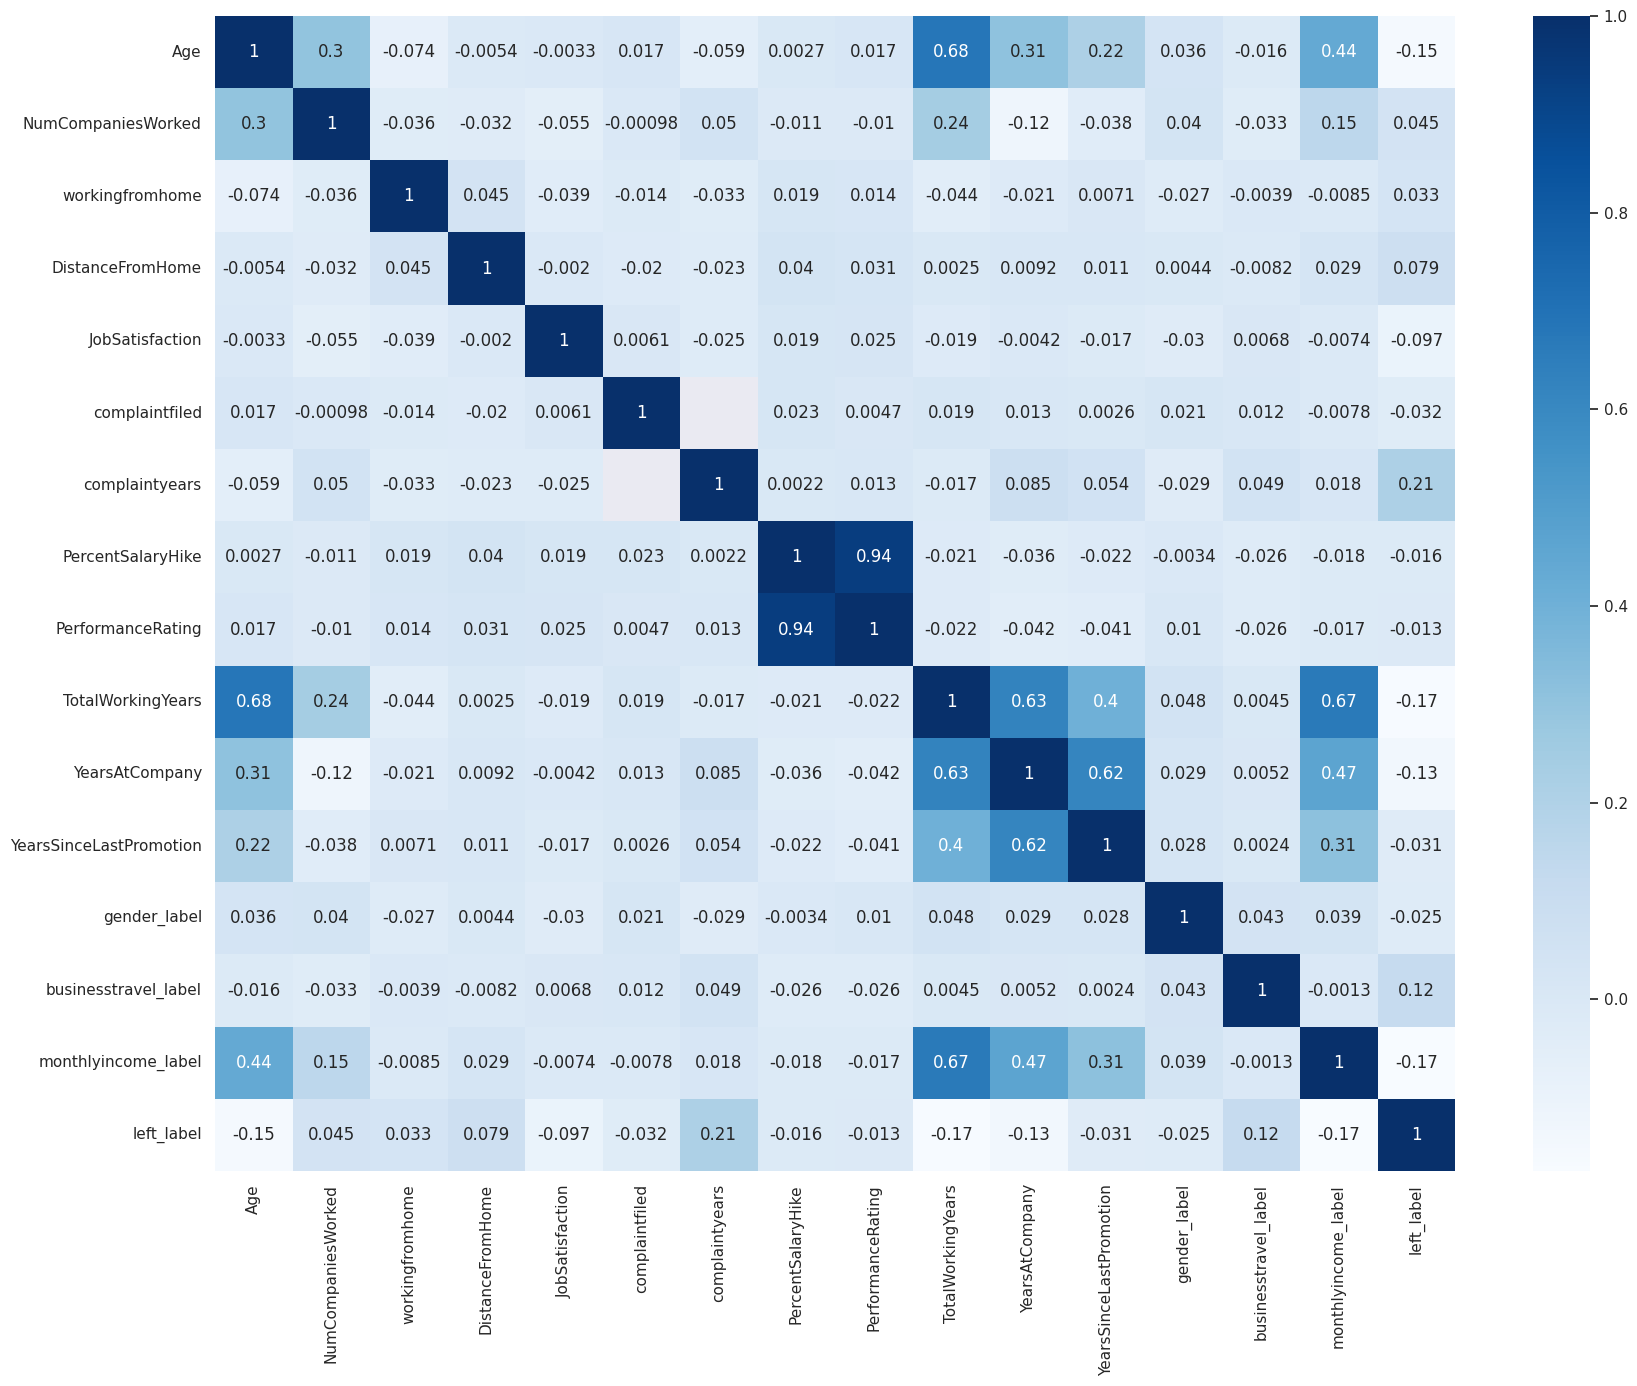

In [17]:
corr = data_clean.corr()
sns.set(rc={'figure.figsize':(20,15)})
sns.heatmap(corr, cmap="Blues", annot=True);

In [18]:
mask_5 = data['PerformanceRating'] == 5.0
mask_4 = data['PerformanceRating'] == 4.0
data_high_p = data[mask_5|mask_4]
data_clean_high_p = data_clean[mask_4 | mask_5]
left_mask = data_high_p['Left'] == 'Yes'


# Data Analysis

In [19]:
data_clean_high_p.groupby(by= 'left_label').mean()

,Age,NumCompaniesWorked,workingfromhome,DistanceFromHome,JobSatisfaction,complaintfiled,complaintyears,PercentSalaryHike,PerformanceRating,TotalWorkingYears,YearsAtCompany,YearsSinceLastPromotion,gender_label,businesstravel_label,monthlyincome_label
left_label,,,,,,,,,,,,,,,
0,37.770833,2.657407,0.483796,9.081019,2.886574,0.215278,1.069767,19.516204,4.504630,11.657407,6.918981,2.037037,0.402778,1.067130,0.979167
1,33.850575,2.735632,0.482759,12.103448,2.310345,0.149425,1.666667,19.229885,4.505747,7.862069,5.057471,1.850575,0.402299,1.183908,0.609195


Observations

The top performing employees who have left have the following significant characteristics versus their high performing colleagues on average:
- Almost 4 years younger
- They live almost 3km further away 
- Their job satisfaction is almost 0.5 points lower
- They are 1/3 less likely to have filed a complaint
- They have 4 less total working years
- They have 2 less years at the company
- Monthly income is around 60% of colleagues who stay


Showing the leaving potential per age group

In [20]:
def age_brackets(x):
    if 18 < x <= 25:
        return '19-25'
    if 25 < x <=32:
        return '26-32'
    if 32 < x <= 39:
        return '33-39'
    if 39 < x <= 46:
        return '40-46'
    if 46 < x <= 53:
        return '47-53'
    else:
        return '54+'
    
data_clean_high_p['age_bracket'] = data_clean_high_p['Age'].apply(age_brackets)

/tmp/ipykernel_3915/3988229453.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean_high_p['age_bracket'] = data_clean_high_p['Age'].apply(age_brackets)


In [22]:
data_age_brackets = data_clean_high_p.groupby(by = 'age_bracket').mean()
age_brackets_quantity = data_clean_high_p.groupby(by = 'age_bracket').count()

In [23]:
data_age_brackets['bracket_quantity'] = age_brackets_quantity['Age']

In [24]:
data_age_brackets.reset_index(inplace = True)

In [26]:
young_mask = data_clean_high_p['Age'] <= 30
young_high_p = data_clean_high_p[young_mask]
young_high_p.groupby(by = 'left_label').count()

#dig into young leavers further - WFH difference, first job maybe, since last promotion, monthlyincome?
# almost twice as many who stayed were able to WFH vs those who left
# 



,Age,Department,NumCompaniesWorked,workingfromhome,DistanceFromHome,JobSatisfaction,complaintfiled,complaintresolved,complaintyears,PercentSalaryHike,PerformanceRating,TotalWorkingYears,YearsAtCompany,YearsSinceLastPromotion,gender_label,businesstravel_label,monthlyincome_label,age_bracket
left_label,,,,,,,,,,,,,,,,,,
0,103,103,103,103,103,103,103,23,21,103,103,103,103,103,103,103,103,103
1,33,33,33,33,33,33,33,5,1,33,33,33,33,33,33,33,33,33


In [29]:
# focus on the 19-30 age group 
left_mask2 = young_high_p['left_label'] == 0
young_stay = young_high_p[left_mask2]
young_left = young_high_p[~left_mask2]
young_stay.mean()


/tmp/ipykernel_3915/4026105454.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  young_stay.mean()


Age                        26.932039
NumCompaniesWorked          1.786408
workingfromhome             0.514563
DistanceFromHome            9.223301
JobSatisfaction             2.864078
complaintfiled              0.223301
complaintyears              1.047619
PercentSalaryHike          19.660194
PerformanceRating           4.524272
TotalWorkingYears           6.291262
YearsAtCompany              5.097087
YearsSinceLastPromotion     1.407767
gender_label                0.368932
businesstravel_label        1.077670
monthlyincome_label         0.640777
left_label                  0.000000
dtype: float64

Showing the rate of leaving for different age groups in a bar plot

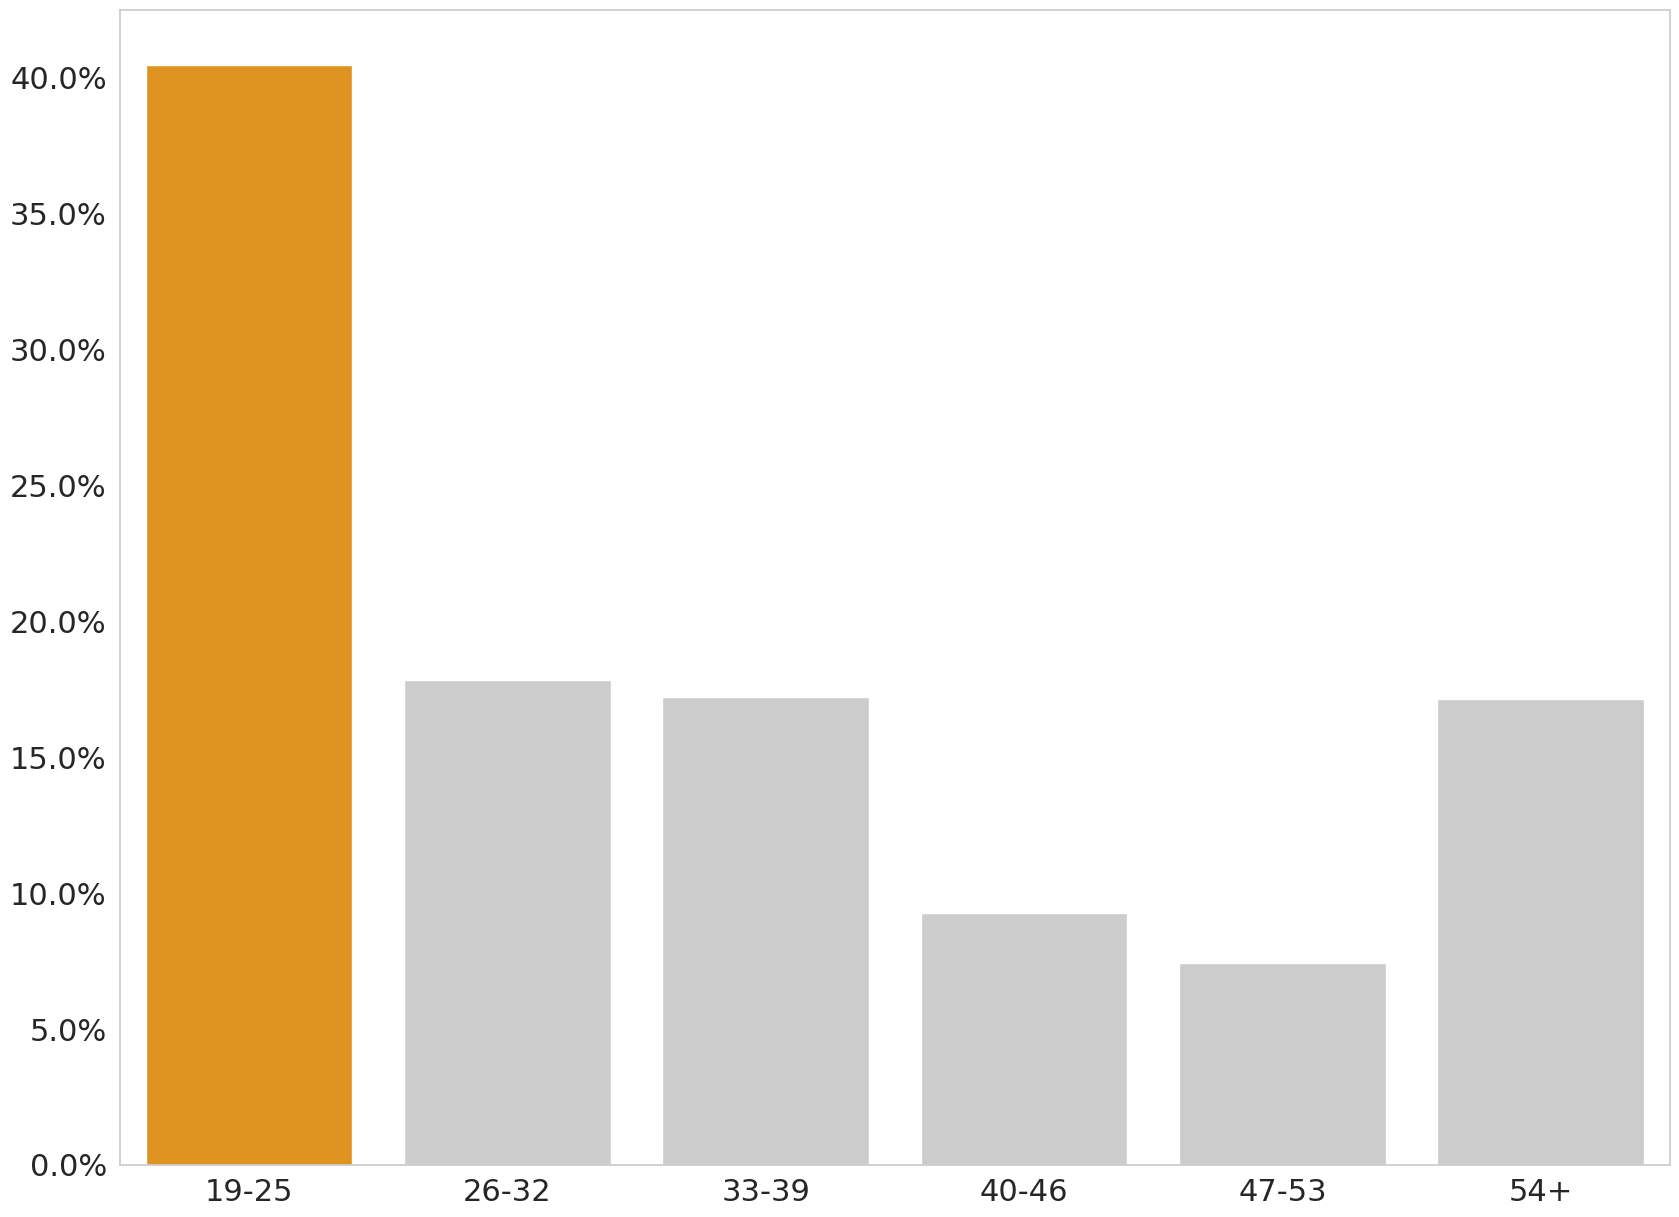

In [30]:
data_age_brackets['left_percentage'] = data_age_brackets['left_label']*100
sns.set(font_scale=2)
sns.set_style("whitegrid")
cols = ['#cccccc' if (x < max(data_age_brackets['left_percentage'])) else '#ff9900' for x in data_age_brackets['left_percentage']]
ax = sns.barplot(data= data_age_brackets, x='age_bracket', y='left_percentage', palette = cols)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(False)


# ax = sns.barplot(x = 'val', y = 'cat', 
#               data = fake, 
#               color = 'black')

ax.set(xlabel='', ylabel='')
plt.show()

Understanding whether there is a relationship between working from home or not, relative to their ability to work from home.

- check if people who work further away from home and can't work from home have a 
- large difference in job satisfaction to the people who can
- then check whether this reflects in their leaving 

In [31]:
data_clean_high_p[data_clean_high_p.columns[1:]].corr()['left_label'][:]

NumCompaniesWorked         0.011752
workingfromhome           -0.000776
DistanceFromHome           0.135089
JobSatisfaction           -0.196283
complaintfiled            -0.061016
complaintyears             0.163325
PercentSalaryHike         -0.043212
PerformanceRating          0.000835
TotalWorkingYears         -0.184582
YearsAtCompany            -0.121041
YearsSinceLastPromotion   -0.022707
gender_label              -0.000365
businesstravel_label       0.081936
monthlyincome_label       -0.182553
left_label                 1.000000
Name: left_label, dtype: float64

In [32]:
# near - med - far

def distance_cat(x):
    if 0 < x <= 10:
        return 'close'
    if 10 < x <= 20:
        return 'medium'
    else:
        return 'far'
    
data_clean_high_p['distance_cat'] = data_clean_high_p['DistanceFromHome'].apply(distance_cat)
distance_brackets_quantity = data_clean_high_p.groupby(by = 'distance_cat').count()
data_distance_brackets = data_clean_high_p.groupby(by = 'distance_cat').mean()
data_distance_brackets['dist_bracket_quantity'] = distance_brackets_quantity['Age']

/tmp/ipykernel_3915/3416806068.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean_high_p['distance_cat'] = data_clean_high_p['DistanceFromHome'].apply(distance_cat)


In [33]:
data_clean_high_p.groupby(by = 'distance_cat').mean()

,Age,NumCompaniesWorked,workingfromhome,DistanceFromHome,JobSatisfaction,complaintfiled,complaintyears,PercentSalaryHike,PerformanceRating,TotalWorkingYears,YearsAtCompany,YearsSinceLastPromotion,gender_label,businesstravel_label,monthlyincome_label,left_label
distance_cat,,,,,,,,,,,,,,,,
close,37.139665,2.745810,0.483240,4.667598,2.770950,0.192737,1.213115,19.497207,4.519553,10.924581,6.502793,1.986034,0.399441,1.086592,0.916201,0.136872
far,36.552941,2.494118,0.505882,25.000000,2.929412,0.188235,1.133333,19.694118,4.576471,12.023529,6.964706,2.305882,0.411765,1.094118,0.941176,0.247059
medium,37.618421,2.513158,0.460526,15.526316,2.723684,0.276316,0.687500,19.078947,4.355263,10.355263,6.697368,1.763158,0.407895,1.078947,0.894737,0.223684


In [34]:
data_clean_high_p.groupby(by = ['JobSatisfaction'])

In [35]:
data_far = data_clean_high_p[data_clean_high_p['distance_cat'] == 'far']

In [36]:
data_far_stay = data_far[data_far['left_label'] == 0]
data_far_left = data_far[data_far['left_label'] == 1]

for people who live far away: businesstravel_label and WFH not helpful

In [37]:
def distance_cat_granular(x):
    if 0 < x <= 5:
        return 'very close'
    if 5 < x <= 10:
        return 'close'
    if 10 < x <= 15:
        return 'low medium'
    if 15 < x <= 20:
        return 'medium'
    if 20 < x <= 25:
        return 'high medium'
    if 25 < x <= 30:
        return 'far'
    else:
        return 'very far'

In [39]:
left_mask2 = data_clean_high_p['left_label'] == 1
data4_stay = data_clean_high_p[~left_mask2]
data4_stay_ages = data4_stay.groupby (by = 'Age').mean()
data4_left = data_clean_high_p[left_mask2]
data4_left_ages = data4_left.groupby (by = 'Age').mean()
data4_stay_ages['MA3JobSatisfaction'] = data4_stay_ages['JobSatisfaction'].rolling(3).mean()
data4_left_ages['MA3JobSatisfaction'] = data4_left_ages['JobSatisfaction'].rolling(3).mean()

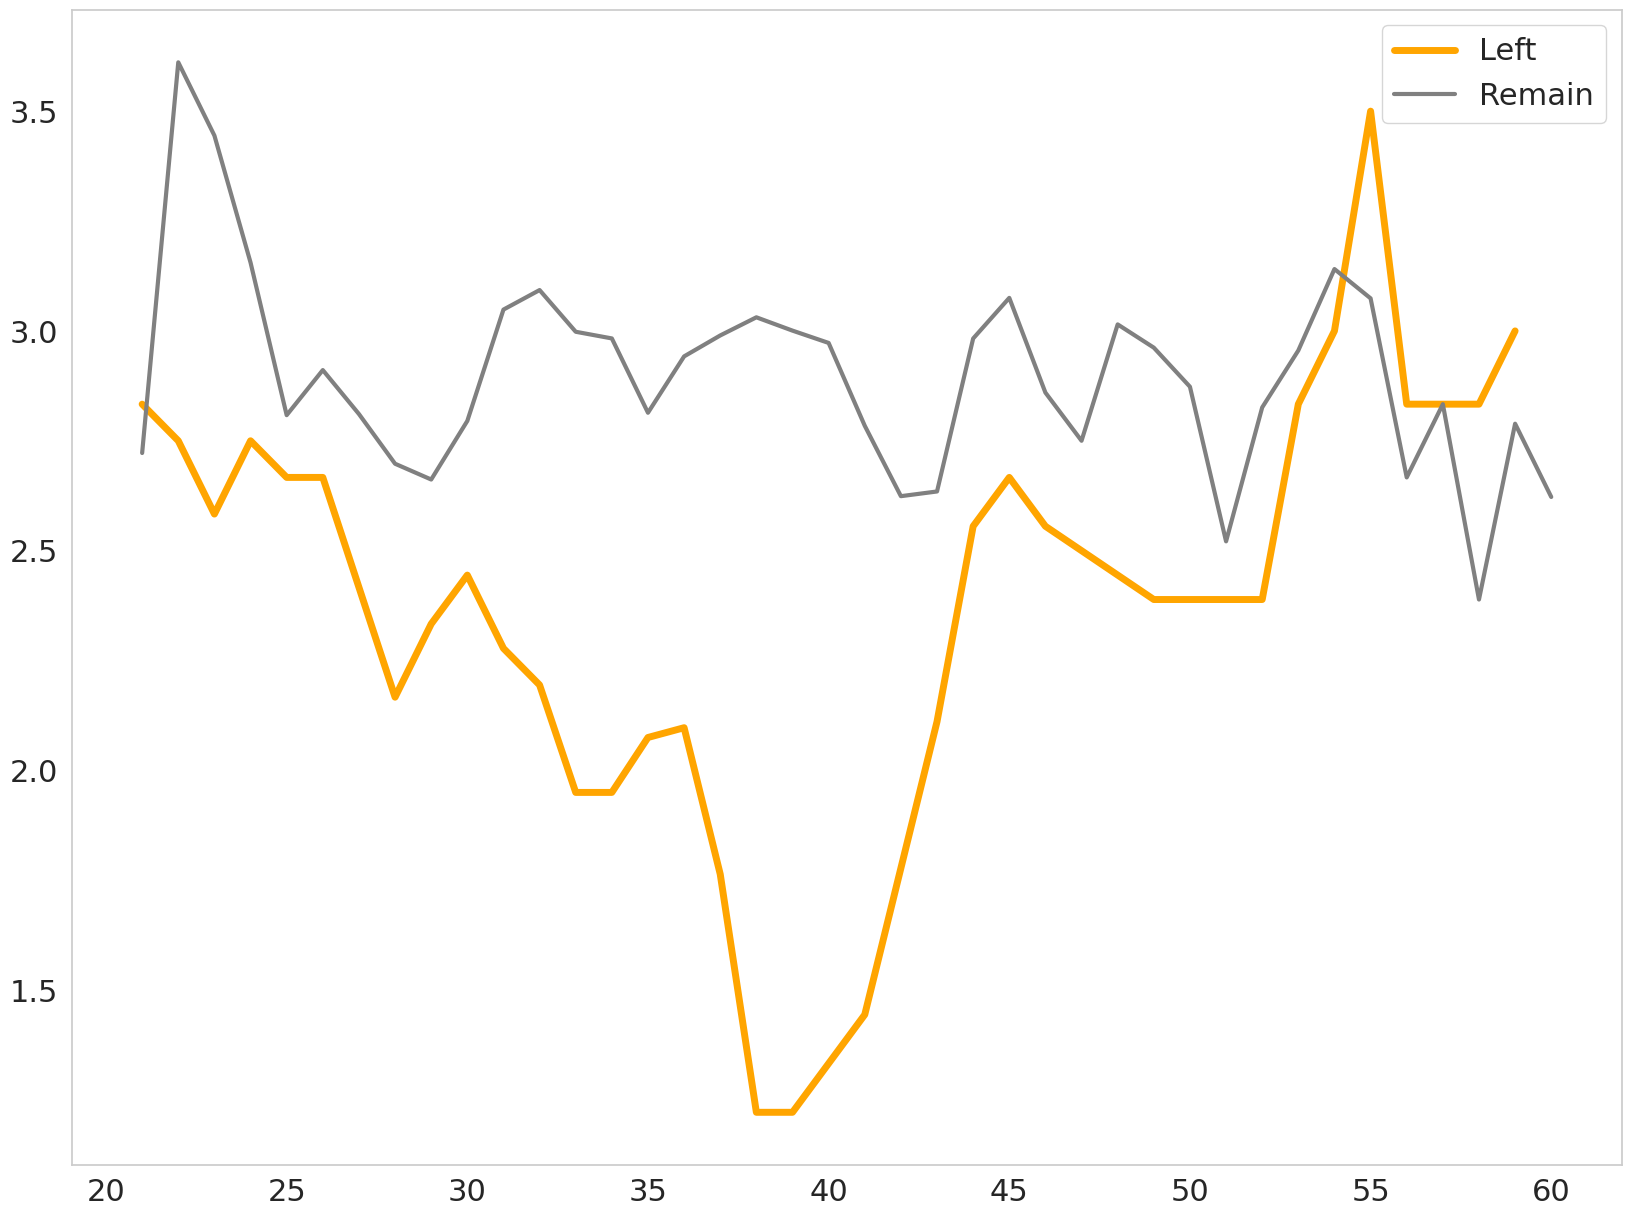

In [40]:
left_mask2 = data_clean_high_p['left_label'] == 1

ax = sns.lineplot(data = data4_left_ages, x = 'Age', y = 'MA3JobSatisfaction', color = 'orange', lw=5)
ax.legend(['Left'])
ax2 = sns.lineplot(data = data4_stay_ages, x = 'Age', y = 'MA3JobSatisfaction', color = 'grey', lw=3)
ax2.legend(['Left','Remain'])
sns.set(font_scale=2)
sns.set_style("whitegrid")


ax.grid(False)
# ax.set(yticklabels=[])
ax.set(ylabel= 'Moving Average Job Satisfaction')  
# ax.set_xticklabels(labels = [0,1,2],rotation=0)


ax.set(xlabel='', ylabel='')
plt.show()


In [41]:
#graph of job satisfaction over salary hikes for leavers and not leavers 
data_clean_high_p.groupby(by = ['left_label','PercentSalaryHike']).mean()

Age  NumCompaniesWorked  workingfromhome  \
left_label PercentSalaryHike                                                   
0          16.0               38.875000            2.718750         0.468750   
           17.0               38.205882            2.867647         0.529412   
           18.0               37.552632            2.592105         0.421053   
           19.0               37.059701            2.567164         0.477612   
           20.0               37.979167            2.666667         0.416667   
           21.0               37.488372            2.534884         0.511628   
           22.0               37.818182            3.000000         0.613636   
           23.0               37.863636            2.954545         0.409091   
           24.0               37.733333            2.733333         0.600000   
           25.0               37.647059            1.294118         0.411765   
1          12.0               31.000000            2.000000         1.000000   
           13.0               54.000000            3.000000         0.000000   
           14.0               59.000000            9.000000         0.000000   
           15.0               35.000000            0.000000         1.000000   
           16.0               38.700000            2.900000         0.500000   
           17.0               32.785714            3.000000         0.500000   
           18.0               34.230769            2.538462         0.538462   
           19.0               28.777778            3.000000         0.222222   
           20.0               32.000000            3.428571         0.857143   
           21.0               30.000000            2.800000         0.400000   
           22.0               33.750000            1.916667         0.416667   
           23.0               32.500000            3.333333         0.666667   
           24.0               37.166667            1.833333         0.333333   
           25.0               19.000000            1.000000         0.000000   

                              DistanceFromHome  JobSatisfaction  \
left_label PercentSalaryHike                                      
0          16.0                      11.031250         2.812500   
           17.0                       8.617647         3.000000   
           18.0                       9.526316         2.973684   
           19.0                       7.970149         2.791045   
           20.0                       8.062500         2.895833   
           21.0                       9.674419         2.651163   
           22.0                       7.659091         2.931818   
           23.0                      12.090909         3.045455   
           24.0                       9.533333         3.000000   
           25.0                      10.411765         2.705882   
1          12.0                      24.000000         4.000000   
           13.0                       1.000000         3.000000   
           14.0                       2.000000         4.000000   
           15.0                      21.000000         4.000000   
           16.0                       8.400000         3.000000   
           17.0                      11.214286         1.571429   
           18.0                      13.846154         2.769231   
           19.0                      12.888889         2.222222   
           20.0                      16.000000         1.714286   
           21.0                       6.000000         1.800000   
           22.0                      14.166667         2.000000   
           23.0                      10.333333         1.833333   
           24.0                      14.000000         3.333333   
           25.0                      10.000000         2.000000   

                              complaintfiled  complaintyears  \
left_label PercentSalaryHike                                   
0          16.0                     0.375000        0.909091   
           17.0     

Encoding Department

In [52]:
data_clean['Department'].value_counts()

Research & Development    963
Sales                     447
Human Resources            64
Name: Department, dtype: int64

In [53]:
def department_encode(x):
    if x == 'Research & Development':
        return 1
    elif x == 'Sales':
        return 2
    elif x == 'Human Resources':
        return 3

In [55]:
data_clean['Department'] = data_clean['Department'].apply(department_encode)

In [57]:
data_clean.to_csv('../data/employee_churn_processed.csv', index = False)